# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Данные**  
Данные геологоразведки трёх регионов находятся в файлах:  
- `/datasets/geo_data_0.csv`.  
- `/datasets/geo_data_1.csv`.   
- `/datasets/geo_data_2.csv`.   

`id` — уникальный идентификатор скважины;  
`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product` — объём запасов в скважине (тыс. баррелей).  

# Подготовка окружения

In [1]:
# !pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np

from scipy import stats as st
from matplotlib import pyplot as plt

from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Загрузка и подготовка данных

Сохраним данные о скважинах трех регионов в переменные `data_0`, `data_1`, `data_2`

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

data_list = [data_0, data_1, data_2]

for i, data in enumerate(data_list):
    print(f'geo_data_{i}', data.shape)

geo_data_0 (100000, 5)
geo_data_1 (100000, 5)
geo_data_2 (100000, 5)


Для каждого датафреймя, выведем на экран информацию.

In [4]:
for i, data in enumerate(data_list):
    display(f'data_{i}', data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'data_0'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'data_1'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'data_2'

None

В каждой таблице содержится 3 признака, id, 100000 объектов, 1 целевая переменная. Пропуски отсутствуют

Выведем на экран по 5 строк из каждой таблицы.

In [5]:
for i, data in enumerate(data_list):
    display(f'data_{i}', data.sample(5, random_state=0))

'data_0'

,id,f0,f1,f2,product
3582,zMatX,0.881376,0.273600,2.770651,49.723143
60498,muBEx,-0.991020,0.010620,3.233630,10.583795
53227,DMAPr,-0.987623,0.017871,5.005426,139.110613
21333,fasrx,2.081966,0.426730,2.638579,85.109875
3885,0XaIy,0.850498,0.473509,3.575604,39.726827


'data_1'

,id,f0,f1,f2,product
3582,gnvG6,13.682535,-1.577749,4.999462,134.766305
60498,KGfJ0,-4.834251,-0.349029,4.996602,137.945408
53227,Km7yX,-7.287642,-4.184750,0.001329,3.179103
21333,bGQtv,-10.041103,-16.919151,3.999895,110.992147
3885,CuYNo,-8.650003,-4.526214,5.012777,137.945408


'data_2'

,id,f0,f1,f2,product
3582,GdnWX,-0.838132,-0.968042,4.074363,129.102262
60498,z2rQ2,0.370981,-0.573846,-3.568113,61.285744
53227,vZROH,0.856767,1.441619,4.895820,65.026246
21333,6AgeD,1.989628,-1.343347,3.242798,62.334048
3885,nXQ8W,2.194257,-2.180922,1.699123,150.002134


Посмотрим также описание данных из каждой таблицы.

In [6]:
for i, data in enumerate(data_list):
    display(f'data_{i}', data.describe())

'data_0'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'data_1'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'data_2'

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Посмотрим как распределены значения признаков в данных для каждого региона.  
Для этого построим гистограммы.

'data_0'

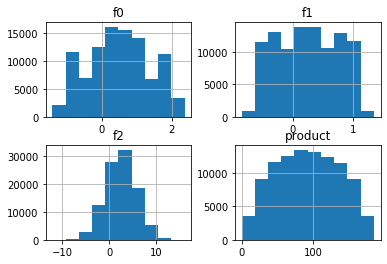

'data_1'

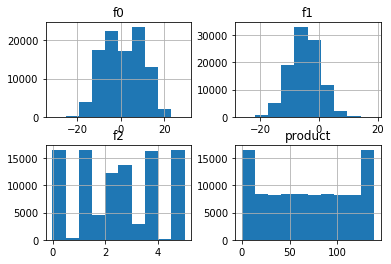

'data_2'

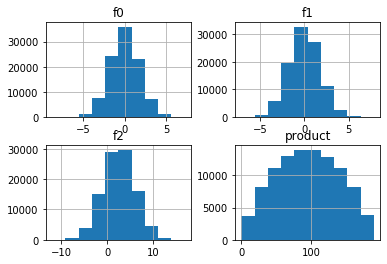

In [7]:
for i, data in enumerate(data_list):
    display(f'data_{i}')
    data.hist();
    plt.show()

Удалим столбец `id`

In [8]:
for i, data in enumerate(data_list):
    data.drop('id', axis=1, inplace=True)
    print(f'data_{i}')
    # Выведем на экран обновленные таблицы
    display(data.head())

data_0


,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


data_1


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


data_2


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


Посмотрим, как коррелируют между собой признаки в каждом из регионов.

In [9]:
for i, data in enumerate(data_list):
    print(f'data_{i}')
    display(data.corr().iloc[:, 0:3])

data_0


,f0,f1,f2
f0,1.000000,-0.440723,-0.003153
f1,-0.440723,1.000000,0.001724
f2,-0.003153,0.001724,1.000000
product,0.143536,-0.192356,0.483663


data_1


,f0,f1,f2
f0,1.000000,0.182287,-0.001777
f1,0.182287,1.000000,-0.002595
f2,-0.001777,-0.002595,1.000000
product,-0.030491,-0.010155,0.999397


data_2


,f0,f1,f2
f0,1.000000,0.000528,-0.000448
f1,0.000528,1.000000,0.000779
f2,-0.000448,0.000779,1.000000
product,-0.001987,-0.001012,0.445871


В первом регионе есть средняя корреляция между признаком `f0` и `f1` (-0.44), а также между признаками `f2` и целевой переменной `product` (0.48). Во втором регионе есть высокая корреляция между признаками `f2` и целевой переменной `product` (0.99). В третьем регионе также наблюдается корреляция между этими признаками средней силы (0.44)

Объеденим данные и вновь посмотрим как коррелируют признаки.

In [10]:
data_full = pd.concat([data_0, data_1, data_2]).reset_index(drop=True)
data_full.shape

(300000, 4)

In [11]:
data_full.corr().iloc[:, 0:3]

,f0,f1,f2
f0,1.000000,0.085495,-0.000849
f1,0.085495,1.000000,0.000002
f2,-0.000849,0.000002,1.000000
product,-0.030439,0.137210,0.533554


Видно, что наиболее сильная линейная связь присутствует между признаками `f2` и целевой переменной `product` (0.53)

Также посмотрим на распределение значений каждого из признаков для общей таблицы.

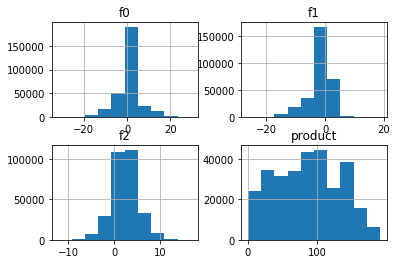

In [12]:
data_full.hist();

### Резюме

На данном этапе мы:
- Открыли данные и ознакомились с ними
- Вкратце оценили распределение значений признаков и корреляции между ними.
- Очистили данные от лишних столбцов

## Обучение и проверка модели

На данном этапе обучим 3 модели для каждого из регионов. Оценим среднее предсказанное моделями значение на валидацонной выборке и среднеквадратичное отклонение.

Приступим.

In [13]:
# Сохраним названия признаков в список features
features=['f0', 'f1', 'f2']

In [14]:
# Разделим данные каждого региона на train и valid

# Первый регион
data_0_train_X, data_0_valid_X, data_0_train_y, data_0_valid_y = train_test_split(data_0[features], data_0['product'], 
   
                                                                                  random_state=0, test_size=0.25)
# Второй регион
data_1_train_X, data_1_valid_X, data_1_train_y, data_1_valid_y = train_test_split(data_1[features], data_1['product'], 
                                                                                  random_state=0, test_size=0.25)

# Третий регион
data_2_train_X, data_2_valid_X, data_2_train_y, data_2_valid_y = train_test_split(data_2[features], data_2['product'], 
                                                                                  random_state=0, test_size=0.25)

Зададим функцию, которая будет возвращать обученную модель и предсказания на валидационной выборке

In [16]:
def make_model(data_train_X, data_valid_X, data_train_y, model):
    # Обучим модель и сделаем предсказания на валидационной выборке
    model.fit(data_train_X, data_train_y)
    data_val_predict = model.predict(data_valid_X)
    
    return model, data_val_predict

Также, зададим модель, которая будет выводить на экран средний запас предсказанного сырья и RMSE модели.

In [17]:
def print_mean_rmse(data_valid_y, data_val_predict):
    print('Средний запас предсказанного сырья:', data_val_predict.mean())
    print('RMSE модели:', mean_squared_error(data_valid_y, data_val_predict)**0.5)

Для каждого из регионов построим отдельную модель и предскажем объем добычи нефти. Используем valid-выборку.  
Предсказания сохраним в переменных `reg_0_val_predict`, `reg_1_val_predict`, `reg_2_val_predict` соответсвенно. 

**Модель для первого региона**

In [18]:
model_0, reg_0_val_predict = make_model(data_0_train_X, data_0_valid_X, data_0_train_y, LinearRegression())
print_mean_rmse(data_0_valid_y, reg_0_val_predict)

Средний запас предсказанного сырья: 92.27144852242301
RMSE модели: 37.48100896950594


Проанализируем результат:  
Ошибка предсказания составляет практически более трети от среднего значения. Это высокий показатель ошибки.

**Модель для второго региона**

In [19]:
model_1, reg_1_val_predict = make_model(data_1_train_X, data_1_valid_X, data_1_train_y, LinearRegression())
print_mean_rmse(data_1_valid_y, reg_1_val_predict)

Средний запас предсказанного сырья: 69.15162398290752
RMSE модели: 0.8872573052219321


Проанализируем результаты:  
Ошибка предсказания составляет менее 1-й тысячи баррелей. Модель для второго региона обладает высокой точностью.

**Модель для третьего региона**

In [20]:
model_2, reg_2_val_predict = make_model(data_2_train_X, data_2_valid_X, data_2_train_y, LinearRegression())
print_mean_rmse(data_2_valid_y, reg_2_val_predict)

Средний запас предсказанного сырья: 94.70753129105672
RMSE модели: 40.31290686044374


Проанализируем результаты:  
Ошибка предсказания составляет почти 50% от среднего предсказанного значения. Это высокий показатель ошибки.

Выведем на экран средний запас предсказанного сырья в регионе и RMSE модели для каждого из регионов.

In [21]:
for i, (true_y, pred) in enumerate([(data_0_valid_y, reg_0_val_predict), 
                                    (data_1_valid_y, reg_1_val_predict),
                                    (data_2_valid_y, reg_2_val_predict)]):
    print(f'Средний запас предсказанного сырья в регионе {i}:', pred.mean())
    print(f'RMSE модели в регионе {i}:', mean_squared_error(true_y, pred)**0.5)
    print('---------')

Средний запас предсказанного сырья в регионе 0: 92.27144852242301
RMSE модели в регионе 0: 37.48100896950594
---------
Средний запас предсказанного сырья в регионе 1: 69.15162398290752
RMSE модели в регионе 1: 0.8872573052219321
---------
Средний запас предсказанного сырья в регионе 2: 94.70753129105672
RMSE модели в регионе 2: 40.31290686044374
---------


**Краткое резюме**

Среднее предсказанное моделями значение находится в диапазоне 69 - 94 тыс. баррелей.  
Корень среднеквадратичной ошибки у предсказаний модели колеблется от 0.89 до 40 тыс. баррелей.  
Модель, построенная для региона 1 обладает достаточно высокой точностью предсказания (ошибка равно 0.89 тыс. баррелей), в то время как ошибка моделей для регионов 0 и 2 является достаточно высокой и составляет около половины от среднего предсказанного значения.

## Подготовка к расчёту прибыли

Сохраним необходимые для расчета прибыли значения в переменных:
- `BUDGET` - бюджет (на развитие 200-т скважин)
- `EARN_PER_BARR` - доход с 1-го барреля
- `NUM_TO_DEV` - количество скважин, для развития в регион
- `budg_per_well` - бюджет на 1-у скважину. Минимальный доход, который требуется от скважины, для достижения безубытка.
- `min_volume_per_well` - минимальный объем сырья, который должна приносить скважина для достижения безубытка

In [25]:
BUDGET = 10*10**9 # Бюджет (на развитие 200-т скважин)
EARN_PER_BARR = 450 # Доход с 1-го барреля
NUM_TO_DEV = 200 # Количество скважин, для развития в регионе

budg_per_well = BUDGET / NUM_TO_DEV # Бюджет на 1-у скважину. Минимальный доход, который требуется от скважины, 
                                    # для достижения безубытка
    
min_volume_per_well = round((budg_per_well / EARN_PER_BARR) / 10**3, 6) # Минимальный объем сырья, который должна приносить скважина
                                                                        # для достижения безубытка

print("Минимальный доход, который должна приносить скважина:", budg_per_well, 'руб.')
print("Минимальный объем сырья, который должна приносить скважина:", min_volume_per_well, "тыс. барр.")

Минимальный доход, который должна приносить скважина: 50000000.0 руб.
Минимальный объем сырья, который должна приносить скважина: 111.111111 тыс. барр.


Напишем функцию для расчета прибыли по предсказанным значениям.

In [27]:
def calculate_true_profit(predicted_volume, true_volume):
    # Если предсказанные значения не являются форматом Series, то мы приводим их в формат Series
    # и задаем индексы из y_valid выборки
    if not isinstance(predicted_volume, pd.core.series.Series):
        indexes = (
            pd.Series(predicted_volume, index=true_volume.index)
            .sort_values(ascending=False)
            .iloc[:200]
            ).index
        true_revenue = true_volume[indexes].sum() * EARN_PER_BARR * 10**3
    
    # Если предсказанные значения уже являются форматом Series, то мы просто считаем прибыль
    else:
        indexes = (
        predicted_volume
        .sort_values(ascending=False)
        .iloc[:200]
        ).index
    true_revenue = true_volume[indexes].sum() * EARN_PER_BARR * 10**3
    
    true_profit = true_revenue - BUDGET
    
    return round(true_profit, 2)

**Краткое резюме**

Среднее предсказанное моделями значение находилось в диапазоне ~79 - 88 тыс.~ 69 - 94 тыс. баррелей. баррелей., при минимальном необходимом объеме в 111.11 тыс. баррелей.  
Показатели среднего объема сырья, предсказанного моделью для каждого из регионов не удовлетворяет минимальным требованиям безубыточности.

## Расчёт прибыли и рисков 

На данном этапе мы:
- Воспользуемся техникой Bootstrap с 1000 выборок, чтобы найти распределение прибыли.  
- Затем, найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого из регионов.
- Выберем регион, наиболее оптимальный для развития скважин с точки зрения прибыли.

In [28]:
# Зададим показатель RandomState
state = np.random.RandomState(0)

Создадим функцию, которая будет возвращать список с 1000-ю значениями прибыли, полученнными в ходе техники Bootstrap

In [30]:
def make_1000_calculations(predicted_volume, true_volume):
    list_with_profits = []
    predicted_volume = pd.Series(predicted_volume, index=true_volume.index)
    
    for i in range(1000):
        sample = resample(predicted_volume, random_state=state, n_samples=500)
        sample_true_profit = calculate_true_profit(sample, true_volume)
        list_with_profits.append(sample_true_profit)
        
    return list_with_profits

Зададим функцию, которая будет возвращать верхнюю и нижнюю границу 95%-го доверительного интервала.

In [32]:
def conf_int_95(array):
    return np.quantile(array, 0.025), np.quantile(array, 0.975)

Вычислим 1000 показателей предсказанной прибыли для каждого из регионов. Данные сохраним в списки `reg_0_profits`, `reg_1_profits`, `reg_2_profits`

In [34]:
reg_0_profits = make_1000_calculations(reg_0_val_predict, data_0_valid_y)
reg_1_profits = make_1000_calculations(reg_1_val_predict, data_1_valid_y)
reg_2_profits = make_1000_calculations(reg_2_val_predict, data_2_valid_y)

Для вычисления риска используем функцию `stats.percentileofscore(array, number, kind='strict')`, где:
- `array` - массив чисел
- `number` - число. Мы хотим узнать, какой процент значений лежит ниже данного числа  

Данная функция возвращает, какая доля от общего количества значений лежит ниже выбранного числа.  
В нашем случае, выбранное число - это 0. Мы хотим узнать, какой процент значений ниже нуля присутсвует в нашем списке прибылей.   
Таким образом, мы можем найти, в каком проценте случаев мы можем получить отрицательную прибыль.

 Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.  
 Результаты сохраним в таблицу `region_table`

In [35]:
region_table = pd.DataFrame({'mean_profit': [np.mean(reg_0_profits), 
                                             np.mean(reg_1_profits), 
                                             np.mean(reg_2_profits)], 
                             'conf_interval_95_min': [conf_int_95(reg_0_profits)[0], 
                                                      conf_int_95(reg_1_profits)[0], 
                                                      conf_int_95(reg_2_profits)[0]], 
                             'conf_interval_95_max': [conf_int_95(reg_0_profits)[1], 
                                                      conf_int_95(reg_1_profits)[1], 
                                                      conf_int_95(reg_2_profits)[1]], 
                             'risk_%': [st.percentileofscore(reg_0_profits, 0, kind='strict'), 
                                        st.percentileofscore(reg_1_profits, 0, kind='strict'), 
                                        st.percentileofscore(reg_2_profits, 0, kind='strict')]
                            }, 
                            index=['region_0', 'region_1', 'region_2']
                           )

region_table

,mean_profit,conf_interval_95_min,conf_interval_95_max,risk_%
region_0,4.428718e+08,-4.923499e+07,9.211347e+08,3.9
region_1,4.695379e+08,8.517891e+07,8.508946e+08,0.8
region_2,3.844244e+08,-1.510246e+08,9.167979e+08,6.9


После оценки рисков нам необходимо оставить лишь те регионы, в которых вероятность убытков меньше 2.5%  

In [47]:
chosen_regions = region_table[region_table['risk_%'] <= 2.5]

chosen_regions

,mean_profit,conf_interval_95_min,conf_interval_95_max,risk_%
region_1,4.695379e+08,8.517891e+07,8.508946e+08,0.8


**Краткое резюме**

Единственный регион, в котором риск получить отрицательную прибыль менее 2.5% - Регион 1. Средняя прибыль, которую мы бы получили в данном регионе, если бы воспользовались предсказаниями модели, составила бы 470 млн. р., при этом наша реальная прибыль с 95% вероятностью находилась бы в диапазоне от 85 млн. р. до 850 млн. р.

## Итог

В ходе работы были проделаны следующие шаги:
1. Были изучены данные о месторожддениях в 3-х регионах
2. Данные были разделены на train и valid выборки.
3. Для каждого региона была обучена модель линейной регресии
4. Для каждого региона было сделано предсказание объема выработки скважин на основании valid-выборки, соответсвующей данному региону. Были получены следующие результаты:

|   |Средний запас предсказанного сырья, тыс. барр | RMSE модели | 
|---|-----------------------------------|-------------|
|Регион 0|92.27|37.48|
|Регион 1|69.15 |0.89 |
|Регион 2|94.71 |40.31 |


5. При помощи техники Bootstrap с 1000 выборок, было найдено распределение прибыли для каждого региона, на основании предсказанного моделью объема добычи. Распределение было сгенерировано следующим образом:
- Случайным образом отбирались 500 месторождений, из которых при помощи модели выбирались 200 лучших. 
- Для этих 200-т месторождений расчитывалась суммарная прибыль, взятая из соответсвующих строк valid-выборки. 
- Данная процедура повторялась 1000 раз.

6. Была найдена средняя прибыль, 95%-й доверительный интервал и риск убытков для каждого из регионов. Были получены следующие результаты:  

|   | mean_profit |	conf_interval_95_min	|	conf_interval_95_max |	risk|
|--|-------------|-------------------------|------------------------|---------|
|region_0 |	4.428718e+08 	|-4.923499e+07 |	9.211347e+08 	|3.9
|region_1 |	4.695379e+08 	|8.517891e+07 |	8.508946e+08 |	0.8
|region_2 |	3.844244e+08 	|-1.510246e+08 |	9.167979e+08 	|6.9



7. Среди 3-х регионов, юыли отобраны те, у которых риск убытка составляет менее 2.5%. Вот их список:

|   | mean_profit |	conf_interval_95_min	|	conf_interval_95_max |	risk|
|--|-------------|-------------------------|------------------------|---------|
|region_1 |	469.5 млн. р. 	|85 млн.р. |	850.8 млн.р |	0.8


**Резюме**  
Таким образом, на основании предсказанных моделью значений и на основании проведенного статистического анализа предсказаний, рекомендуется вести разработку скважин в Регионе 1.   
Средняя прибыль, которую можно получить в данном регионе составляет 469.5млн. р., при этом с 95%-й вероятностью действительная прибыль будет лежать в диапазоне от 85 млн.р. до 850.8 млн. р. Риск получить убыток в данном регионе составляет 0.8%